In [1]:
import sys
import os

repo_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_path)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src import portfolio_maker, agent
agentPairs = agent.PortfolioChangeAnalyzerPairs
agentUSD = agent.PortfolioChangeAnalyzerUSD
ASRP = portfolio_maker.ASRP
HRP = portfolio_maker.HRP
IVP = portfolio_maker.IVP
MVP = portfolio_maker.MVP

# Set options to display all columns and float format to 2 decimal places
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.2f}')

In [3]:
# Define functions to evaluate investment performance
def calculate_portfolio_returns(returns_matrix, weights):
    return (returns_matrix * weights).sum(axis=1)

def calculate_cumulative_returns(returns_matrix, weights):
    """
    Calculate cumulative returns for a portfolio given returns and weights.

    Parameters:
    - returns_matrix: DataFrame of asset returns
    - weights: Series of portfolio weights

    Returns:
    - Series of cumulative returns
    """
    portfolio_returns = calculate_portfolio_returns(returns_matrix, weights)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    return cumulative_returns

def calculate_total_return(cumulative_returns):
    """Calculate total return over the entire period"""
    return cumulative_returns.iloc[-1] - 1

def calculate_roi(cumulative_returns):
    """Calculate Return on Investment (ROI) as percentage"""
    return (cumulative_returns.iloc[-1] - 1) * 100

def calculate_annualized_volatility(returns, periods_per_year=365):
    """Calculate annualized volatility"""
    return returns.std() * np.sqrt(periods_per_year)

def calculate_sharpe_ratio(returns, risk_free_rate=0, periods_per_year=365):
    """
    Calculate Sharpe Ratio
    Default risk-free rate of 0% and 365 trading days per year
    """
    excess_returns = returns - risk_free_rate/periods_per_year
    return np.sqrt(periods_per_year) * (excess_returns.mean() / returns.std())

def calculate_sortino_ratio(returns, risk_free_rate=0, periods_per_year=365):
    """Calculate Sortino Ratio using only downside volatility"""
    excess_returns = returns - risk_free_rate/periods_per_year
    downside_returns = returns[returns < 0]
    downside_std = np.sqrt(np.mean(downside_returns**2))
    return np.sqrt(periods_per_year) * (excess_returns.mean() / downside_std)

def calculate_drawdowns(cumulative_returns):
    """Calculate drawdown series"""
    rolling_max = cumulative_returns.expanding().max()
    drawdowns = cumulative_returns/rolling_max - 1
    return drawdowns

def calculate_max_drawdown(cumulative_returns):
    """Calculate Maximum Drawdown"""
    drawdowns = calculate_drawdowns(cumulative_returns)
    return drawdowns.min()

def calculate_calmar_ratio(returns, cumulative_returns, periods_per_year=365):
    """Calculate Calmar Ratio (annualized return / max drawdown)"""
    annualized_return = (cumulative_returns.iloc[-1]**(periods_per_year/len(returns)) - 1)
    max_drawdown = abs(calculate_max_drawdown(cumulative_returns))
    return annualized_return / max_drawdown

def calculate_performance_metrics(returns_matrix=None, weights=None, portfolio_returns=None, cumulative_returns=None):
    """
    Calculate comprehensive performance metrics for a portfolio
    
    Parameters:
    - returns_matrix: DataFrame of asset returns (optional if portfolio_returns and cumulative_returns provided)
    - weights: Series of portfolio weights (optional if portfolio_returns and cumulative_returns provided)
    - portfolio_returns: Series of portfolio returns (optional if returns_matrix and weights provided)
    - cumulative_returns: Series of cumulative returns (optional if returns_matrix and weights provided)
    
    Returns:
    - Dictionary containing all performance metrics
    """
    if portfolio_returns is None or cumulative_returns is None:
        if returns_matrix is None or weights is None:
            raise ValueError("Must provide either (returns_matrix, weights) or (portfolio_returns, cumulative_returns)")
        portfolio_returns = (returns_matrix * weights).sum(axis=1)
        cumulative_returns = calculate_cumulative_returns(returns_matrix, weights)
    
    metrics = {
        'Total Return (%)': float(calculate_roi(cumulative_returns)),
        'Annualized Volatility (%)': float(calculate_annualized_volatility(portfolio_returns) * 100),
        'Sharpe Ratio': float(calculate_sharpe_ratio(portfolio_returns)),
        'Sortino Ratio': float(calculate_sortino_ratio(portfolio_returns)), 
        'Maximum Drawdown (%)': float(calculate_max_drawdown(cumulative_returns) * 100),
        'Calmar Ratio': float(calculate_calmar_ratio(portfolio_returns, cumulative_returns))
    }
    
    return metrics

def plot_performance_metrics(metrics_dict):
    """
    Plot performance metrics as bar plots with log scale in a single subplot
    
    Parameters:
    - metrics_dict: Dictionary containing performance metrics for different portfolios
    """
    # Get metrics names and prepare data for plotting
    metrics_names = list(next(iter(metrics_dict.values())).keys())
    portfolios = list(metrics_dict.keys())
    
    # Create figure
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Calculate bar positions
    n_metrics = len(metrics_names)
    n_portfolios = len(portfolios)
    width = 0.8 / n_metrics
    x = np.arange(n_portfolios)
    
    # Plot bars for each metric
    for i, metric in enumerate(metrics_names):
        values = [metrics_dict[portfolio][metric] for portfolio in portfolios]
        positions = x + (i - n_metrics/2 + 0.5) * width
        
        # Create bar plot
        bars = ax.bar(positions, values, width, label=metric)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}',
                   ha='center', va='bottom', rotation=45)
    
    # Customize plot
    ax.set_xticks(x)
    ax.set_xticklabels(portfolios, rotation=45)
    ax.set_title('Portfolio Performance Metrics Comparison')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    # Set log scale if all values are positive
    if all(val > 0 for metric in metrics_dict.values() for val in metric.values()):
        ax.set_yscale('log')
    
    plt.tight_layout()
    return plt

In [4]:
# Load DataFrame
data = pd.read_csv(os.path.join('..','data','binance_usdt_pairs_2018-12-31_2024-01-01_1d.csv'))
data['open_time'] = pd.to_datetime(data['open_time'])
print(data.shape)
data.head()

(426165, 13)


,symbol,open_time,open,high,low,close,volume,close_time,quote_volume,num_trades,taker_base_vol,taker_quote_vol,ignore
0,1000SATSUSDT,2023-12-12,0.00,0.00,0.00,0.00,624844140259.00,2023-12-12 23:59:59.999,340399289.88,995522,318852251409.00,174388930.76,0
1,1000SATSUSDT,2023-12-13,0.00,0.00,0.00,0.00,317546611755.00,2023-12-13 23:59:59.999,157167392.37,444221,158103387848.00,78333443.71,0
2,1000SATSUSDT,2023-12-14,0.00,0.00,0.00,0.00,778688810259.00,2023-12-14 23:59:59.999,511889240.81,1390517,399140907213.00,262301084.13,0
3,1000SATSUSDT,2023-12-15,0.00,0.00,0.00,0.00,902204913462.00,2023-12-15 23:59:59.999,732922339.08,2325998,450689519636.00,367398491.91,0
4,1000SATSUSDT,2023-12-16,0.00,0.00,0.00,0.00,405020284175.00,2023-12-16 23:59:59.999,312792279.99,940263,196177438805.00,151753298.50,0


#### Filtramos los datos para eliminar los pares de stablecoins

In [5]:
# list of stablecoin pairs
stablecoin_pairs = [
    'USDCUSDT',    # USD Coin
    'BUSDUSDT',    # Binance USD
    'DAIUSDT',     # DAI
    'TUSDUSDT',    # True USD
    'USDPUSDT',    # Pax Dollar
    'GUSDUSDT',    # Gemini Dollar
    'FDUSDT',      # First Digital USD
    'PYUSDUSDT',   # PayPal USD
    'LUSDUSDT',    # Liquity USD
    'USDSUSDT',    # Stably USD
    'SUSDUSDT',    # sUSD (Synthetix USD)
    'CUSDUSDT',    # Celo Dollar
    'USDXUSDT',    # USDX [Kava]
    'FRAXUSDT',    # Frax
    'USDDUSDT',    # USDD
    'FDUSDUSDT',   # First Digital USD
    'PAXUSDT',     # Paxos Standard
    'USDSBUSDT'    # StableUSD (USDS)
]

# Filter data for non-stablecoin pairs
filtered_data = data[~data['symbol'].isin(stablecoin_pairs)]

# Sort table by open_time, ascending, and reset index
filtered_data = filtered_data.sort_values(by='open_time', ascending=True).reset_index(drop=True)

print(filtered_data.shape)
filtered_data.head()

(418366, 13)


,symbol,open_time,open,high,low,close,volume,close_time,quote_volume,num_trades,taker_base_vol,taker_quote_vol,ignore
0,QTUMUSDT,2019-01-01,2.12,2.25,2.10,2.23,110950.42,2019-01-01 23:59:59.999,239699.45,2615,59529.42,128789.92,0
1,BCHSVUSDT,2019-01-01,83.88,94.88,83.23,90.79,164228.86,2019-01-01 23:59:59.999,14825047.18,51919,80107.53,7228702.47,0
2,BTCUSDT,2019-01-01,3701.23,3810.16,3642.00,3797.14,23741.69,2019-01-01 23:59:59.999,88149249.09,154227,12919.16,47973435.87,0
3,NEOUSDT,2019-01-01,7.42,7.79,7.28,7.76,324745.14,2019-01-01 23:59:59.999,2430436.39,8615,161815.74,1212410.89,0
4,ETCUSDT,2019-01-01,4.98,5.25,4.93,5.25,261033.68,2019-01-01 23:59:59.999,1321405.06,6415,141648.99,718234.40,0


In [6]:
# Make a series with the weights of the buy and hold strategy
hodl_BTC = pd.Series({'BTCUSDT': 1.0})
hodl_ETH = pd.Series({'ETHUSDT': 1.0})

#### Separamos los retornos de los primeros 2 años para armar el portafolio

In [7]:
# Transform data to returns and drop pairs with insufficient data
returns = (
    filtered_data
    .pivot(
        columns='symbol',
        values='close',
        index='open_time'
    )
    .iloc[:365*2+1]  # Keep first 2 years of daily data (+1)
    .pct_change(fill_method=None)
    .iloc[1:]  # Drop first row
    .dropna(axis=1, how='any')  # Drop columns with any NaN values after the first row drop
)
print(returns.shape)
returns.head()

(730, 17)


symbol,ADAUSDT,BNBUSDT,BTCUSDT,EOSUSDT,ETCUSDT,ETHUSDT,ICXUSDT,IOTAUSDT,LTCUSDT,NEOUSDT,NULSUSDT,ONTUSDT,QTUMUSDT,TRXUSDT,VETUSDT,XLMUSDT,XRPUSDT
open_time,,,,,,,,,,,,,,,,,
2019-01-02,0.06,0.01,0.02,0.08,0.01,0.09,0.04,0.06,0.04,0.02,0.03,0.06,0.04,0.02,0.01,0.03,0.02
2019-01-03,-0.05,-0.04,-0.02,-0.06,-0.06,-0.04,0.03,-0.04,-0.04,-0.05,-0.03,-0.06,-0.06,-0.00,-0.04,-0.04,-0.04
2019-01-04,0.02,0.03,0.01,0.01,0.04,0.04,0.05,-0.00,0.01,-0.01,0.02,0.01,0.02,0.07,0.01,0.01,0.00
2019-01-05,0.02,-0.00,-0.01,-0.01,-0.03,0.01,-0.02,-0.01,0.08,0.04,0.04,0.03,0.00,0.04,-0.01,-0.01,-0.01
2019-01-06,0.10,0.05,0.06,0.06,0.06,0.01,0.07,0.02,0.12,0.10,0.03,0.04,0.04,0.03,0.06,0.06,0.03


#### Armamos los portafolios estaticos y evaluamos su performance

In [8]:
hrp_strategy = HRP(returns)
hrp_weights = hrp_strategy.get_weights()

ivp_strategy = IVP(returns)
ivp_weights = ivp_strategy.get_weights()

mvp_strategy = MVP(returns)
mvp_weights = mvp_strategy.get_weights()

asrp_strategy = ASRP(returns)
asrp_weights = asrp_strategy.get_weights()

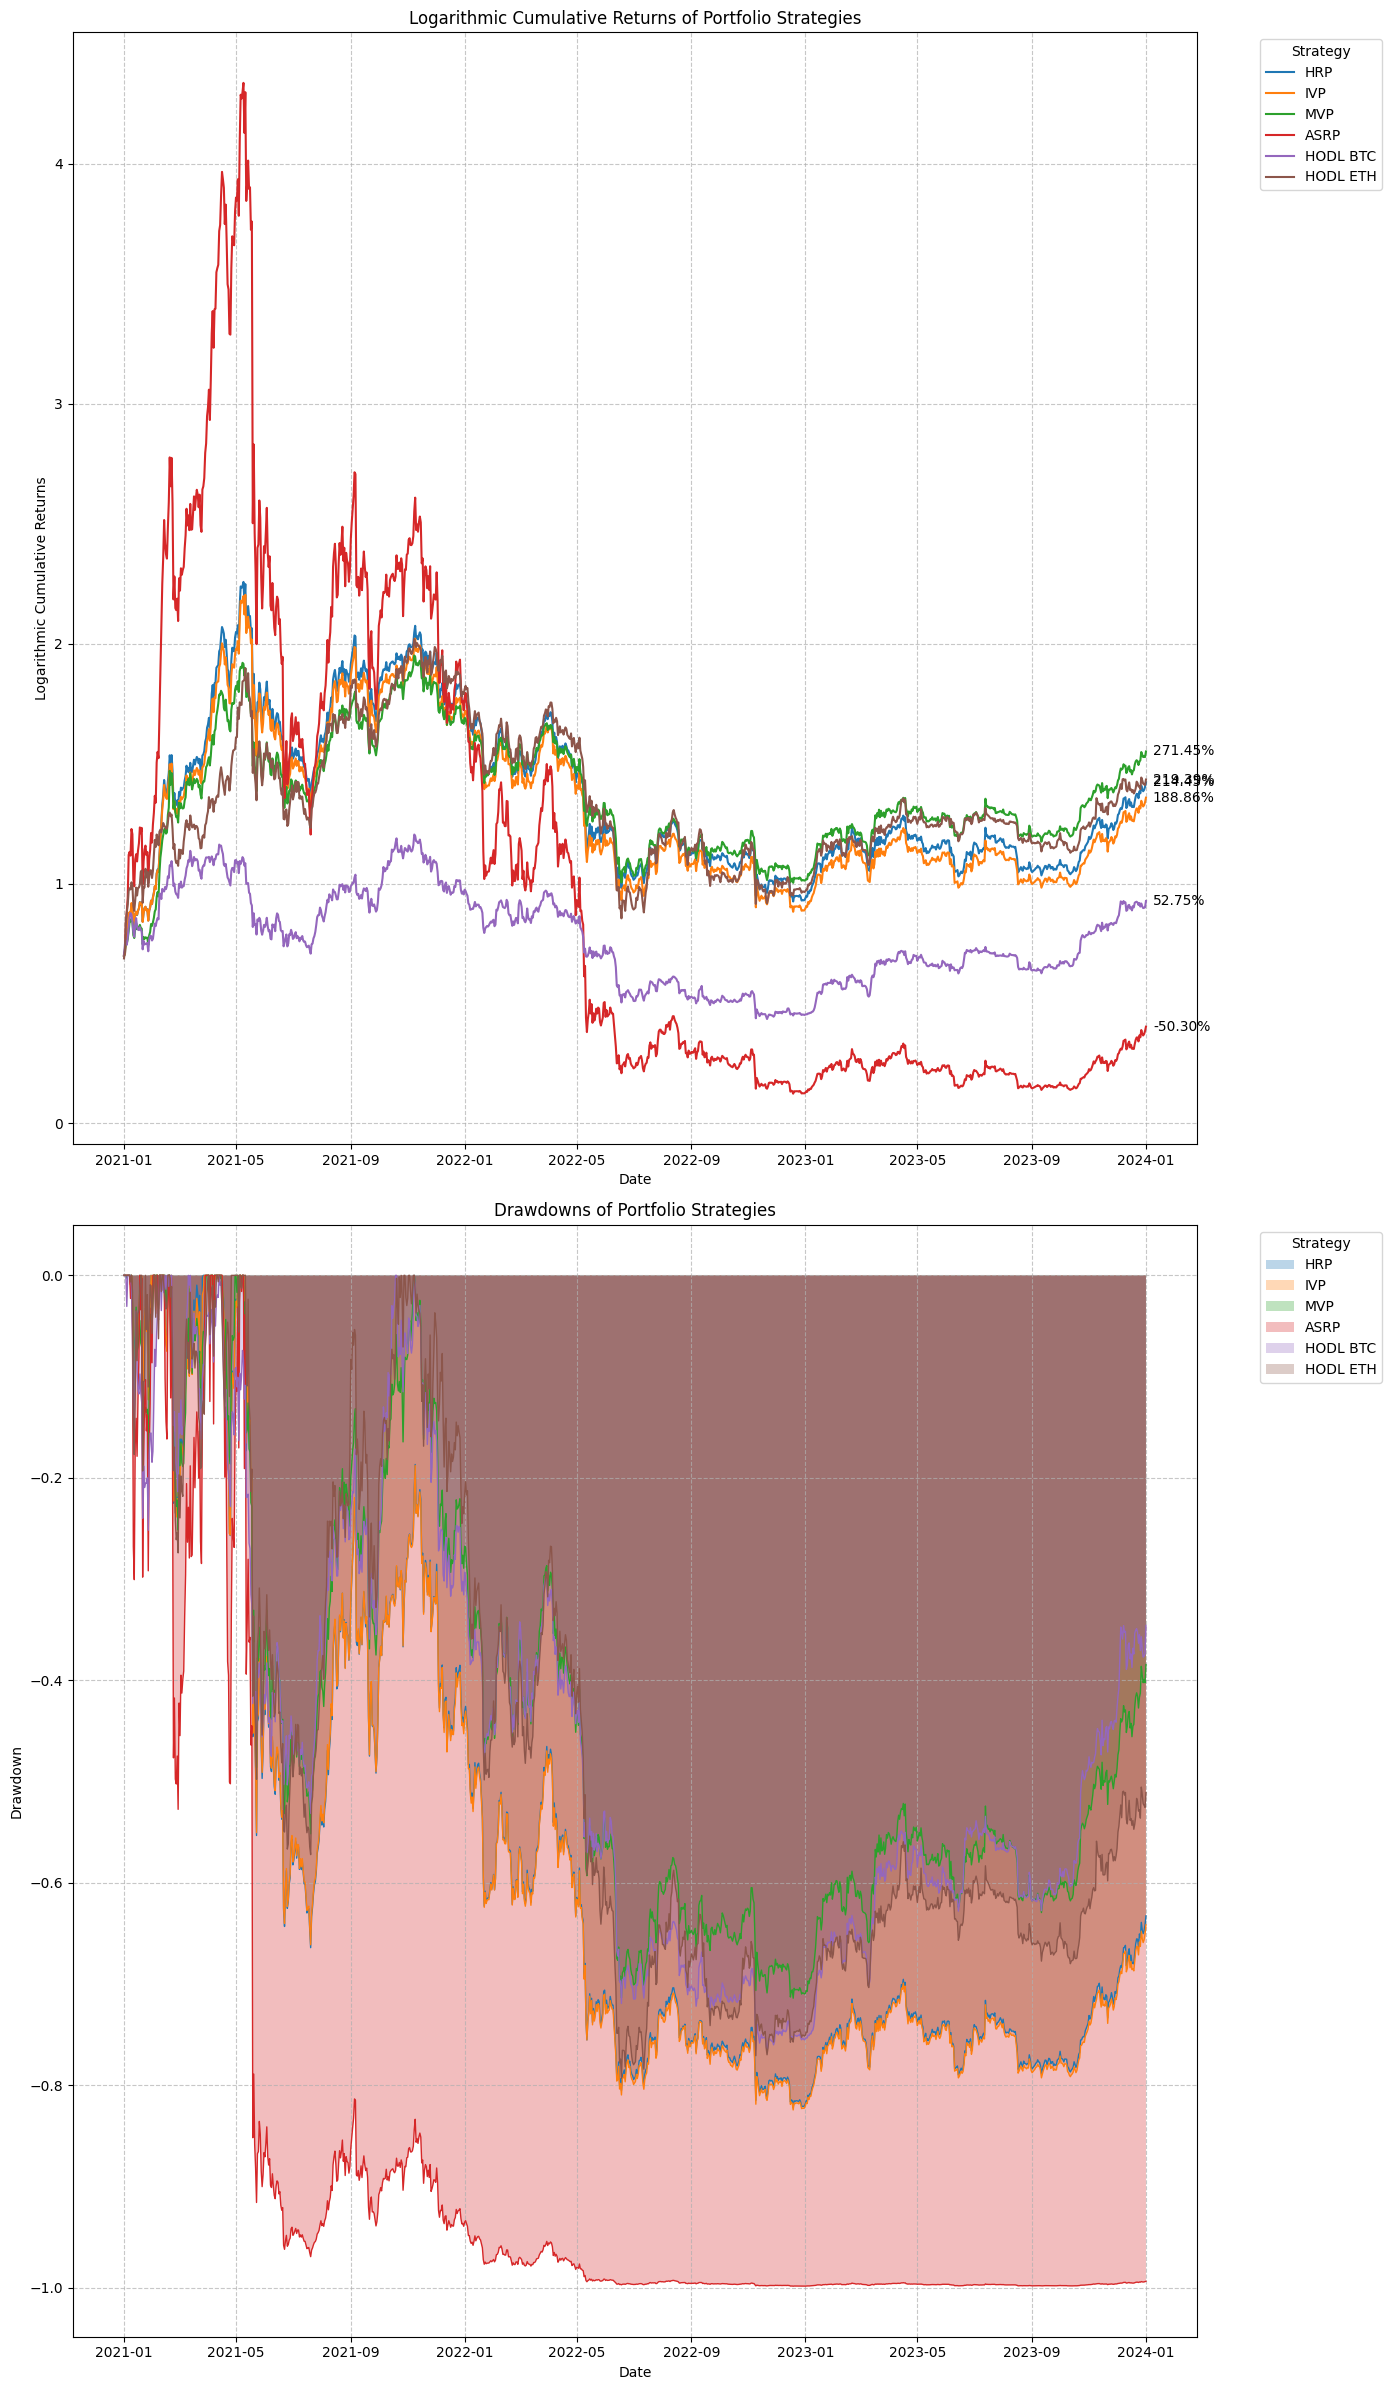

In [9]:
# Transform data to returns
backtest_returns = (
    filtered_data
    .pivot(
        columns='symbol',
        values='close',
        index='open_time'
    )
    .iloc[365*2:]  # Get data after first 2 years of daily data
    .pct_change(fill_method=None)
    .iloc[1:]  # Drop first row
)

# Filter and sort backtest_returns in order to match returns used for the strategies
backtest_returns = backtest_returns[returns.columns]

# Calculate cumulative returns for portfolio strategies
hrp_cumulative = calculate_cumulative_returns(backtest_returns, hrp_weights)
ivp_cumulative = calculate_cumulative_returns(backtest_returns, ivp_weights)
mvp_cumulative = calculate_cumulative_returns(backtest_returns, mvp_weights)
asrp_cumulative = calculate_cumulative_returns(backtest_returns, asrp_weights)

# Calculate cumulative returns for HODL strategies
btc_cumulative = calculate_cumulative_returns(backtest_returns, hodl_BTC)
eth_cumulative = calculate_cumulative_returns(backtest_returns, hodl_ETH)

cumulative_returns = pd.DataFrame({
    "HRP": hrp_cumulative,
    "IVP": ivp_cumulative,
    "MVP": mvp_cumulative,
    "ASRP": asrp_cumulative,
    "HODL BTC": btc_cumulative,
    "HODL ETH": eth_cumulative
})

# Calculate drawdowns for portfolio strategies
hrp_drawdowns = calculate_drawdowns(hrp_cumulative)
ivp_drawdowns = calculate_drawdowns(ivp_cumulative) 
mvp_drawdowns = calculate_drawdowns(mvp_cumulative)
asrp_drawdowns = calculate_drawdowns(asrp_cumulative)

# Calculate drawdowns for HODL strategies
btc_drawdowns = calculate_drawdowns(btc_cumulative)
eth_drawdowns = calculate_drawdowns(eth_cumulative)

drawdowns = pd.DataFrame({
    "HRP": hrp_drawdowns,
    "IVP": ivp_drawdowns,
    "MVP": mvp_drawdowns,
    "ASRP": asrp_drawdowns,
    "HODL BTC": btc_drawdowns,
    "HODL ETH": eth_drawdowns
})

# Create figure with two subplots
fig = plt.figure(figsize=(14, 24))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])

# Plot cumulative returns as a line chart
ax1 = fig.add_subplot(gs[0])
for col in cumulative_returns.columns:
    line = ax1.plot(cumulative_returns.index, np.log1p(cumulative_returns[col]), label=col)
    # Add final value annotation with ROI percentage
    final_value = (cumulative_returns[col].iloc[-1] - 1) * 100
    ax1.annotate(f'{final_value:.2f}%', 
                 xy=(cumulative_returns.index[-1], np.log1p(cumulative_returns[col].iloc[-1])),
                 xytext=(5, 0), textcoords='offset points', 
                 va='center')
ax1.set_title("Logarithmic Cumulative Returns of Portfolio Strategies")
ax1.set_xlabel("Date")
ax1.set_ylabel("Logarithmic Cumulative Returns")
ax1.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot drawdowns as an area chart
ax2 = fig.add_subplot(gs[1])
for col in drawdowns.columns:
    ax2.fill_between(drawdowns.index, drawdowns[col], alpha=0.3, label=col)
    ax2.plot(drawdowns.index, drawdowns[col], linewidth=1)
ax2.set_title("Drawdowns of Portfolio Strategies")
ax2.set_xlabel("Date")
ax2.set_ylabel("Drawdown")
ax2.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

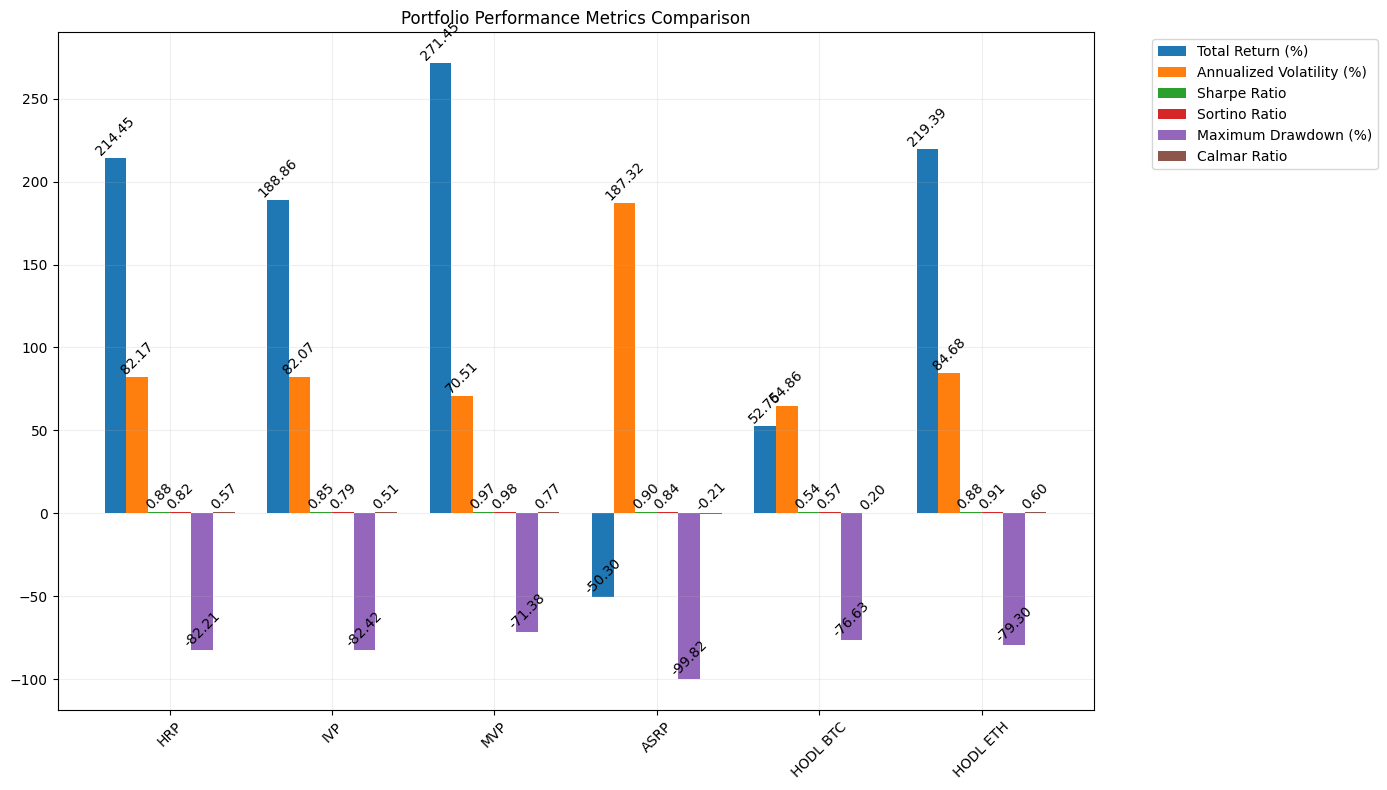

In [10]:
# calculate_performance_metrics(returns_matrix=None, weights=None, portfolio_returns=None, cumulative_returns=None)

# Calculate portfolio returns for all strategies including HODL
btc_returns = calculate_portfolio_returns(backtest_returns, hodl_BTC)
eth_returns = calculate_portfolio_returns(backtest_returns, hodl_ETH)

metrics_dict = {
    'HRP': calculate_performance_metrics(returns_matrix=backtest_returns, weights=hrp_weights),
    'IVP': calculate_performance_metrics(returns_matrix=backtest_returns, weights=ivp_weights),
    'MVP': calculate_performance_metrics(returns_matrix=backtest_returns, weights=mvp_weights),
    'ASRP': calculate_performance_metrics(returns_matrix=backtest_returns, weights=asrp_weights),
    'HODL BTC': calculate_performance_metrics(portfolio_returns=btc_returns, cumulative_returns=btc_cumulative),
    'HODL ETH': calculate_performance_metrics(portfolio_returns=eth_returns, cumulative_returns=eth_cumulative)
}
plot_performance_metrics(metrics_dict);

#### Armamos portafolios dinamicos y evaluamos su performance

##### USD cost transactions

In [11]:
# Set the number of days for rebalancing and the window size for the dynamic strategies
rebalancing_days = 30 # days
window_size = 365*2 # 2 years of daily data

# Transform data to returns
backtest_returns = (
    filtered_data
    .pivot(
        columns='symbol',
        values='close',
        index='open_time'
    )
    .iloc[window_size:window_size+rebalancing_days+1]  # Get data for rebalancing days after window size (+1)
    .pct_change(fill_method=None)
    .iloc[1:]  # Drop first row
)

# Filter and sort backtest_returns in order to match returns used for the strategies
backtest_returns = backtest_returns[returns.columns]

# Calculate portfolio returns
hrp_returns = calculate_portfolio_returns(backtest_returns, hrp_weights)
ivp_returns = calculate_portfolio_returns(backtest_returns, ivp_weights)
mvp_returns = calculate_portfolio_returns(backtest_returns, mvp_weights)
asrp_returns = calculate_portfolio_returns(backtest_returns, asrp_weights)

portfolio_returns_dynamic = pd.DataFrame({
    "HRP": hrp_returns,
    "IVP": ivp_returns,
    "MVP": mvp_returns,
    "ASRP": asrp_returns
})

# Calculate cumulative returns
hrp_cumulative = calculate_cumulative_returns(backtest_returns, hrp_weights)
ivp_cumulative = calculate_cumulative_returns(backtest_returns, ivp_weights)
mvp_cumulative = calculate_cumulative_returns(backtest_returns, mvp_weights)
asrp_cumulative = calculate_cumulative_returns(backtest_returns, asrp_weights)

cumulative_returns_dynamic = pd.DataFrame({
    "HRP": hrp_cumulative,
    "IVP": ivp_cumulative,
    "MVP": mvp_cumulative,
    "ASRP": asrp_cumulative
})

# Calculate change between first day prices and final day prices of the backtest returns
first_day_prices = filtered_data.pivot(columns='symbol', values='close', index='open_time').loc[backtest_returns.index.min()]
final_day_prices = filtered_data.pivot(columns='symbol', values='close', index='open_time').loc[backtest_returns.index.max()]
price_change = final_day_prices / first_day_prices

# Calculate the new weights based on the price change
new_weights = {
    "HRP": hrp_weights * price_change[hrp_weights.index] / (hrp_weights * price_change[hrp_weights.index]).sum(),
    "IVP": ivp_weights * price_change[ivp_weights.index] / (ivp_weights * price_change[ivp_weights.index]).sum(),
    "MVP": mvp_weights * price_change[mvp_weights.index] / (mvp_weights * price_change[mvp_weights.index]).sum(),
    "ASRP": asrp_weights * price_change[asrp_weights.index] / (asrp_weights * price_change[asrp_weights.index]).sum()
}

In [12]:
# Calculate number of possible periods
total_periods = (len(filtered_data['open_time'].unique()) - window_size - rebalancing_days) // rebalancing_days

# Initialize dictionaries to accumulate transactions and their costs for each strategy
total_transactions = {"ASRP": 0, "HRP": 0, "IVP": 0, "MVP": 0}
total_costs = {"ASRP": 0.0, "HRP": 0.0, "IVP": 0.0, "MVP": 0.0}

# Set old returns from the new weights
asrp_old = new_weights["ASRP"].copy()
hrp_old = new_weights["HRP"].copy()
ivp_old = new_weights["IVP"].copy()
mvp_old = new_weights["MVP"].copy()

# For each period
for period in range(1, total_periods + 2): # start from the second period, add +2 to include the last period of backtest
    # Calculate window start and end indices
    window_start = period * rebalancing_days
    window_end = window_start + window_size
    backtest = window_end + rebalancing_days
    
    # Get returns data
    returns = (
        filtered_data
        .pivot(
            columns='symbol',
            values='close',
            index='open_time'
        )
        .iloc[window_start:window_end+1] # (+1)
        .pct_change(fill_method=None)
        .iloc[1:]  # Drop first row
        .dropna(axis=1, how='any')  # Drop any columns with missing data
    )
    
    # Calculate new weights using the returns data
    asrp_new = ASRP(returns).get_weights()
    hrp_new = HRP(returns).get_weights()
    ivp_new = IVP(returns).get_weights()
    mvp_new = MVP(returns).get_weights()

    # Evaluate the transition for ASRP strategy
    asrp_analyzer = agentUSD(asrp_old, asrp_new, returns)
    asrp_analysis = asrp_analyzer.analyze_transition(min_improvement_threshold=0.001)
    
    if asrp_analysis['recommendation']:
        total_transactions["ASRP"] += 1
        total_costs["ASRP"] += asrp_analysis['transaction_costs']
        cumulative_returns_dynamic.loc[cumulative_returns_dynamic.index.max(), 'ASRP'] -= asrp_analysis['transaction_costs']
        asrp_old = asrp_new.copy()
    
    # Evaluate the transition for HRP strategy
    hrp_analyzer = agentUSD(hrp_old, hrp_new, returns)
    hrp_analysis = hrp_analyzer.analyze_transition(min_improvement_threshold=0.001)
    
    if hrp_analysis['recommendation']:
        total_transactions["HRP"] += 1
        total_costs["HRP"] += hrp_analysis['transaction_costs']
        cumulative_returns_dynamic.loc[cumulative_returns_dynamic.index.max(), 'HRP'] -= hrp_analysis['transaction_costs']
        hrp_old = hrp_new.copy()
    
    # Evaluate the transition for IVP strategy
    ivp_analyzer = agentUSD(ivp_old, ivp_new, returns)
    ivp_analysis = ivp_analyzer.analyze_transition(min_improvement_threshold=0.001)
    
    if ivp_analysis['recommendation']:
        total_transactions["IVP"] += 1
        total_costs["IVP"] += ivp_analysis['transaction_costs']
        cumulative_returns_dynamic.loc[cumulative_returns_dynamic.index.max(), 'IVP'] -= ivp_analysis['transaction_costs']
        ivp_old = ivp_new.copy()
    
    # Evaluate the transition for MVP strategy
    mvp_analyzer = agentUSD(mvp_old, mvp_new, returns)
    mvp_analysis = mvp_analyzer.analyze_transition(min_improvement_threshold=0.001)
    
    if mvp_analysis['recommendation']:
        total_transactions["MVP"] += 1
        total_costs["MVP"] += mvp_analysis['transaction_costs']
        cumulative_returns_dynamic.loc[cumulative_returns_dynamic.index.max(), 'MVP'] -= mvp_analysis['transaction_costs']
        mvp_old = mvp_new.copy()
    
    # Get backtest data
    backtest_returns = (
        filtered_data
        .pivot(
            columns='symbol',
            values='close',
            index='open_time'
        )
        .iloc[window_end:backtest+1] # (+1)
        .pct_change(fill_method=None)
        .iloc[1:] # Drop first row
    )
    
    # Align backtest data columns with the weights of each strategy
    asrp_backtest_returns = backtest_returns[asrp_old.index]
    hrp_backtest_returns = backtest_returns[hrp_old.index]
    ivp_backtest_returns = backtest_returns[ivp_old.index]
    mvp_backtest_returns = backtest_returns[mvp_old.index]
    
    # Calculate portfolio returns for this period
    hrp_ret = calculate_portfolio_returns(hrp_backtest_returns, hrp_old)
    ivp_ret = calculate_portfolio_returns(ivp_backtest_returns, ivp_old)
    mvp_ret = calculate_portfolio_returns(mvp_backtest_returns, mvp_old)
    asrp_ret = calculate_portfolio_returns(asrp_backtest_returns, asrp_old)

    portfolio_returns_together = pd.DataFrame({
        "HRP": hrp_ret,
        "IVP": ivp_ret,
        "MVP": mvp_ret,
        "ASRP": asrp_ret
    })

    # Calculate cumulative returns for this period
    hrp_cum = calculate_cumulative_returns(hrp_backtest_returns, hrp_old)
    ivp_cum = calculate_cumulative_returns(ivp_backtest_returns, ivp_old)
    mvp_cum = calculate_cumulative_returns(mvp_backtest_returns, mvp_old)
    asrp_cum = calculate_cumulative_returns(asrp_backtest_returns, asrp_old)

    cumulative_returns_together = pd.DataFrame({
        "HRP": hrp_cum,
        "IVP": ivp_cum,
        "MVP": mvp_cum,
        "ASRP": asrp_cum
    })

    # Concatenate the returns for each period
    portfolio_returns_dynamic = pd.concat([portfolio_returns_dynamic, portfolio_returns_together])
    cumulative_returns_dynamic = pd.concat([cumulative_returns_dynamic, cumulative_returns_together])

    # Calculate change between first day prices and final day prices of the backtest returns
    first_day_prices = filtered_data.pivot(columns='symbol', values='close', index='open_time').loc[backtest_returns.index.min()]
    final_day_prices = filtered_data.pivot(columns='symbol', values='close', index='open_time').loc[backtest_returns.index.max()]
    price_change = final_day_prices / first_day_prices

    # Calculate the new weights based on the price change
    hrp_old = hrp_old * price_change[hrp_old.index] / (hrp_old * price_change[hrp_old.index]).sum()
    ivp_old = ivp_old * price_change[ivp_old.index] / (ivp_old * price_change[ivp_old.index]).sum()
    mvp_old = mvp_old * price_change[mvp_old.index] / (mvp_old * price_change[mvp_old.index]).sum()
    asrp_old = asrp_old * price_change[asrp_old.index] / (asrp_old * price_change[asrp_old.index]).sum()

In [13]:
set(cumulative_returns_dynamic.index.value_counts())

{1}

In [14]:
total_transactions

{'ASRP': 3, 'HRP': 3, 'IVP': 2, 'MVP': 2}

In [15]:
total_costs

{'ASRP': np.float64(0.004126860996067072),
 'HRP': np.float64(0.0025447501196310864),
 'IVP': np.float64(0.0015637094619052885),
 'MVP': np.float64(0.0023685615047365624)}

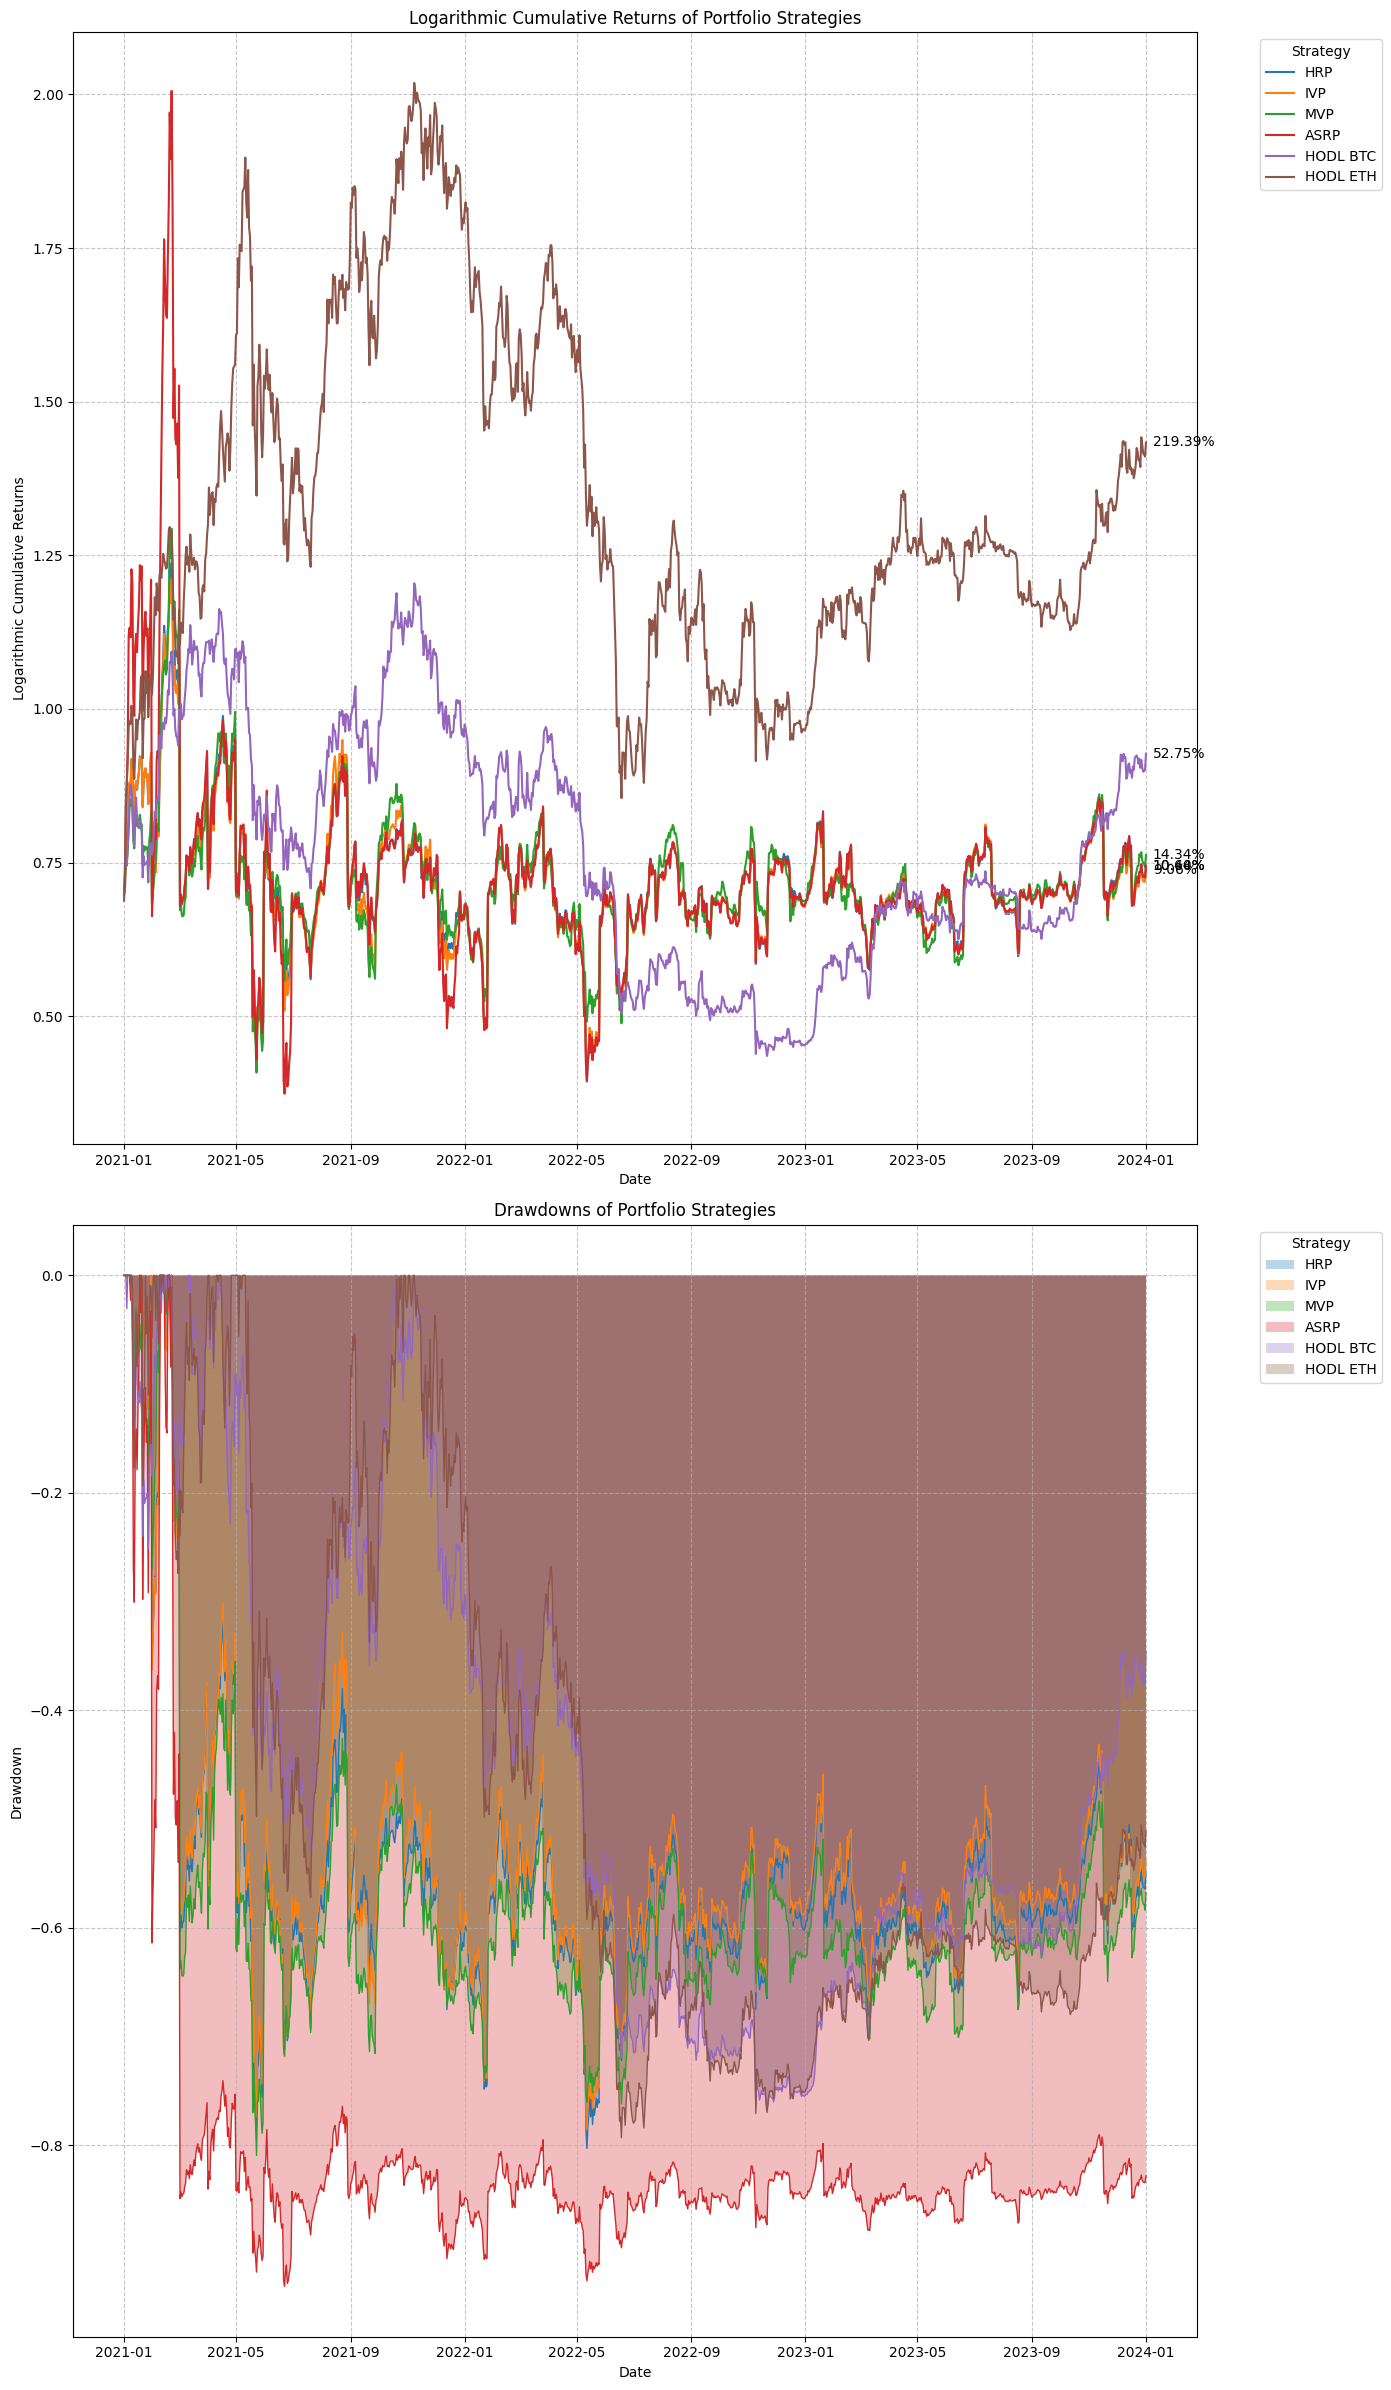

In [16]:
# Add HODL strategies to cumulative returns dataframe
cumulative_returns_dynamic["HODL BTC"] = btc_cumulative
cumulative_returns_dynamic["HODL ETH"] = eth_cumulative

# Calculate drawdowns
hrp_drawdowns = calculate_drawdowns(cumulative_returns_dynamic["HRP"])
ivp_drawdowns = calculate_drawdowns(cumulative_returns_dynamic["IVP"]) 
mvp_drawdowns = calculate_drawdowns(cumulative_returns_dynamic["MVP"])
asrp_drawdowns = calculate_drawdowns(cumulative_returns_dynamic["ASRP"])

drawdowns = pd.DataFrame({
    "HRP": hrp_drawdowns,
    "IVP": ivp_drawdowns,
    "MVP": mvp_drawdowns,
    "ASRP": asrp_drawdowns,
    "HODL BTC": btc_drawdowns,
    "HODL ETH": eth_drawdowns
})

# Create figure with two subplots
fig = plt.figure(figsize=(14, 24))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])

# Plot cumulative returns as a line chart
ax1 = fig.add_subplot(gs[0])
for col in cumulative_returns_dynamic.columns:
    line = ax1.plot(cumulative_returns_dynamic.index, np.log1p(cumulative_returns_dynamic[col]), label=col)
    # Add final value annotation with ROI percentage
    final_value = (cumulative_returns_dynamic[col].iloc[-1] - 1) * 100
    ax1.annotate(f'{final_value:.2f}%', 
                 xy=(cumulative_returns_dynamic.index[-1], np.log1p(cumulative_returns_dynamic[col].iloc[-1])),
                 xytext=(5, 0), textcoords='offset points', 
                 va='center')
ax1.set_title("Logarithmic Cumulative Returns of Portfolio Strategies")
ax1.set_xlabel("Date")
ax1.set_ylabel("Logarithmic Cumulative Returns")
ax1.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot drawdowns as an area chart
ax2 = fig.add_subplot(gs[1])
for col in drawdowns.columns:
    ax2.fill_between(drawdowns.index, drawdowns[col], alpha=0.3, label=col)
    ax2.plot(drawdowns.index, drawdowns[col], linewidth=1)
ax2.set_title("Drawdowns of Portfolio Strategies")
ax2.set_xlabel("Date")
ax2.set_ylabel("Drawdown")
ax2.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

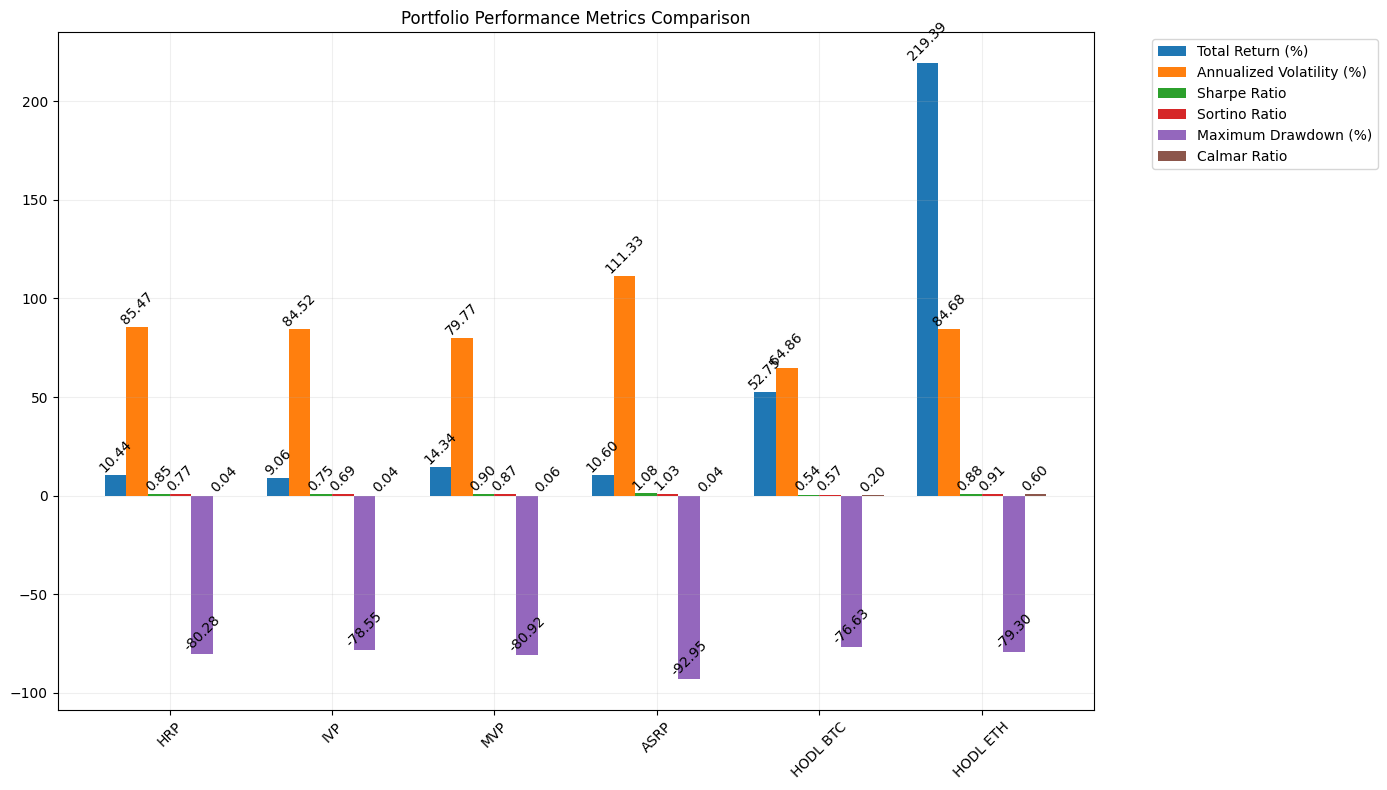

In [17]:
# calculate_performance_metrics(returns_matrix=None, weights=None, portfolio_returns=None, cumulative_returns=None)
metrics_dict = {
    'HRP': calculate_performance_metrics(portfolio_returns=portfolio_returns_dynamic['HRP'], cumulative_returns=cumulative_returns_dynamic['HRP']),
    'IVP': calculate_performance_metrics(portfolio_returns=portfolio_returns_dynamic['IVP'], cumulative_returns=cumulative_returns_dynamic['IVP']),
    'MVP': calculate_performance_metrics(portfolio_returns=portfolio_returns_dynamic['MVP'], cumulative_returns=cumulative_returns_dynamic['MVP']),
    'ASRP': calculate_performance_metrics(portfolio_returns=portfolio_returns_dynamic['ASRP'], cumulative_returns=cumulative_returns_dynamic['ASRP']),
    'HODL BTC': calculate_performance_metrics(portfolio_returns=btc_returns, cumulative_returns=btc_cumulative),
    'HODL ETH': calculate_performance_metrics(portfolio_returns=eth_returns, cumulative_returns=eth_cumulative)
}
plot_performance_metrics(metrics_dict);

##### Pairs cost transactions

In [18]:
# Set the number of days for rebalancing and the window size for the dynamic strategies
rebalancing_days = 30 # days
window_size = 365*2 # 2 years of daily data

# Transform data to returns
backtest_returns = (
    filtered_data
    .pivot(
        columns='symbol',
        values='close',
        index='open_time'
    )
    .iloc[window_size:window_size+rebalancing_days+1]  # Get data for rebalancing days after window size (+1)
    .pct_change(fill_method=None)
    .iloc[1:]  # Drop first row
)

# Filter and sort backtest_returns in order to match returns used for the strategies
backtest_returns = backtest_returns[returns.columns]

# Calculate portfolio returns
hrp_returns = calculate_portfolio_returns(backtest_returns, hrp_weights)
ivp_returns = calculate_portfolio_returns(backtest_returns, ivp_weights)
mvp_returns = calculate_portfolio_returns(backtest_returns, mvp_weights)
asrp_returns = calculate_portfolio_returns(backtest_returns, asrp_weights)

portfolio_returns_dynamic = pd.DataFrame({
    "HRP": hrp_returns,
    "IVP": ivp_returns,
    "MVP": mvp_returns,
    "ASRP": asrp_returns
})

# Calculate cumulative returns
hrp_cumulative = calculate_cumulative_returns(backtest_returns, hrp_weights)
ivp_cumulative = calculate_cumulative_returns(backtest_returns, ivp_weights)
mvp_cumulative = calculate_cumulative_returns(backtest_returns, mvp_weights)
asrp_cumulative = calculate_cumulative_returns(backtest_returns, asrp_weights)

cumulative_returns_dynamic = pd.DataFrame({
    "HRP": hrp_cumulative,
    "IVP": ivp_cumulative,
    "MVP": mvp_cumulative,
    "ASRP": asrp_cumulative
})

# Calculate change between first day prices and final day prices of the backtest returns
first_day_prices = filtered_data.pivot(columns='symbol', values='close', index='open_time').loc[backtest_returns.index.min()]
final_day_prices = filtered_data.pivot(columns='symbol', values='close', index='open_time').loc[backtest_returns.index.max()]
price_change = final_day_prices / first_day_prices

# Calculate the new weights based on the price change
new_weights = {
    "HRP": hrp_weights * price_change[hrp_weights.index] / (hrp_weights * price_change[hrp_weights.index]).sum(),
    "IVP": ivp_weights * price_change[ivp_weights.index] / (ivp_weights * price_change[ivp_weights.index]).sum(),
    "MVP": mvp_weights * price_change[mvp_weights.index] / (mvp_weights * price_change[mvp_weights.index]).sum(),
    "ASRP": asrp_weights * price_change[asrp_weights.index] / (asrp_weights * price_change[asrp_weights.index]).sum()
}

In [19]:
# Calculate number of possible periods
total_periods = (len(filtered_data['open_time'].unique()) - window_size - rebalancing_days) // rebalancing_days

# Initialize dictionaries to accumulate transactions and their costs for each strategy
total_transactions = {"ASRP": 0, "HRP": 0, "IVP": 0, "MVP": 0}
total_costs = {"ASRP": 0.0, "HRP": 0.0, "IVP": 0.0, "MVP": 0.0}

# Set old returns from the new weights
asrp_old = new_weights["ASRP"].copy()
hrp_old = new_weights["HRP"].copy()
ivp_old = new_weights["IVP"].copy()
mvp_old = new_weights["MVP"].copy()

# For each period
for period in range(1, total_periods + 2): # start from the second period, add +2 to include the last period of backtest
    # Calculate window start and end indices
    window_start = period * rebalancing_days
    window_end = window_start + window_size
    backtest = window_end + rebalancing_days
    
    # Get returns data
    returns = (
        filtered_data
        .pivot(
            columns='symbol',
            values='close',
            index='open_time'
        )
        .iloc[window_start:window_end+1] # (+1)
        .pct_change(fill_method=None)
        .iloc[1:]  # Drop first row
        .dropna(axis=1, how='any')  # Drop any columns with missing data
    )
    
    # Calculate new weights using the returns data
    asrp_new = ASRP(returns).get_weights()
    hrp_new = HRP(returns).get_weights()
    ivp_new = IVP(returns).get_weights()
    mvp_new = MVP(returns).get_weights()

    # Evaluate the transition for ASRP strategy
    asrp_analyzer = agentPairs(asrp_old, asrp_new, returns)
    asrp_analysis = asrp_analyzer.analyze_transition(min_improvement_threshold=0.001)
    
    if asrp_analysis['recommendation']:
        total_transactions["ASRP"] += 1
        total_costs["ASRP"] += asrp_analysis['transaction_costs']
        cumulative_returns_dynamic.loc[cumulative_returns_dynamic.index.max(), 'ASRP'] -= asrp_analysis['transaction_costs']
        asrp_old = asrp_new.copy()
    
    # Evaluate the transition for HRP strategy
    hrp_analyzer = agentPairs(hrp_old, hrp_new, returns)
    hrp_analysis = hrp_analyzer.analyze_transition(min_improvement_threshold=0.001)
    
    if hrp_analysis['recommendation']:
        total_transactions["HRP"] += 1
        total_costs["HRP"] += hrp_analysis['transaction_costs']
        cumulative_returns_dynamic.loc[cumulative_returns_dynamic.index.max(), 'HRP'] -= hrp_analysis['transaction_costs']
        hrp_old = hrp_new.copy()
    
    # Evaluate the transition for IVP strategy
    ivp_analyzer = agentPairs(ivp_old, ivp_new, returns)
    ivp_analysis = ivp_analyzer.analyze_transition(min_improvement_threshold=0.001)
    
    if ivp_analysis['recommendation']:
        total_transactions["IVP"] += 1
        total_costs["IVP"] += ivp_analysis['transaction_costs']
        cumulative_returns_dynamic.loc[cumulative_returns_dynamic.index.max(), 'IVP'] -= ivp_analysis['transaction_costs']
        ivp_old = ivp_new.copy()
    
    # Evaluate the transition for MVP strategy
    mvp_analyzer = agentPairs(mvp_old, mvp_new, returns)
    mvp_analysis = mvp_analyzer.analyze_transition(min_improvement_threshold=0.001)
    
    if mvp_analysis['recommendation']:
        total_transactions["MVP"] += 1
        total_costs["MVP"] += mvp_analysis['transaction_costs']
        cumulative_returns_dynamic.loc[cumulative_returns_dynamic.index.max(), 'MVP'] -= mvp_analysis['transaction_costs']
        mvp_old = mvp_new.copy()
    
    # Get backtest data
    backtest_returns = (
        filtered_data
        .pivot(
            columns='symbol',
            values='close',
            index='open_time'
        )
        .iloc[window_end:backtest+1] # (+1)
        .pct_change(fill_method=None)
        .iloc[1:] # Drop first row
    )
    
    # Align backtest data columns with the weights of each strategy
    asrp_backtest_returns = backtest_returns[asrp_old.index]
    hrp_backtest_returns = backtest_returns[hrp_old.index]
    ivp_backtest_returns = backtest_returns[ivp_old.index]
    mvp_backtest_returns = backtest_returns[mvp_old.index]
    
    # Calculate portfolio returns for this period
    hrp_ret = calculate_portfolio_returns(hrp_backtest_returns, hrp_old)
    ivp_ret = calculate_portfolio_returns(ivp_backtest_returns, ivp_old)
    mvp_ret = calculate_portfolio_returns(mvp_backtest_returns, mvp_old)
    asrp_ret = calculate_portfolio_returns(asrp_backtest_returns, asrp_old)

    portfolio_returns_together = pd.DataFrame({
        "HRP": hrp_ret,
        "IVP": ivp_ret,
        "MVP": mvp_ret,
        "ASRP": asrp_ret
    })

    # Calculate cumulative returns for this period
    hrp_cum = calculate_cumulative_returns(hrp_backtest_returns, hrp_old)
    ivp_cum = calculate_cumulative_returns(ivp_backtest_returns, ivp_old)
    mvp_cum = calculate_cumulative_returns(mvp_backtest_returns, mvp_old)
    asrp_cum = calculate_cumulative_returns(asrp_backtest_returns, asrp_old)

    cumulative_returns_together = pd.DataFrame({
        "HRP": hrp_cum,
        "IVP": ivp_cum,
        "MVP": mvp_cum,
        "ASRP": asrp_cum
    })

    # Concatenate the returns for each period
    portfolio_returns_dynamic = pd.concat([portfolio_returns_dynamic, portfolio_returns_together])
    cumulative_returns_dynamic = pd.concat([cumulative_returns_dynamic, cumulative_returns_together])

    # Calculate change between first day prices and final day prices of the backtest returns
    first_day_prices = filtered_data.pivot(columns='symbol', values='close', index='open_time').loc[backtest_returns.index.min()]
    final_day_prices = filtered_data.pivot(columns='symbol', values='close', index='open_time').loc[backtest_returns.index.max()]
    price_change = final_day_prices / first_day_prices

    # Calculate the new weights based on the price change
    hrp_old = hrp_old * price_change[hrp_old.index] / (hrp_old * price_change[hrp_old.index]).sum()
    ivp_old = ivp_old * price_change[ivp_old.index] / (ivp_old * price_change[ivp_old.index]).sum()
    mvp_old = mvp_old * price_change[mvp_old.index] / (mvp_old * price_change[mvp_old.index]).sum()
    asrp_old = asrp_old * price_change[asrp_old.index] / (asrp_old * price_change[asrp_old.index]).sum()

In [20]:
set(cumulative_returns_dynamic.index.value_counts())

{1}

In [21]:
total_transactions

{'ASRP': 3, 'HRP': 3, 'IVP': 2, 'MVP': 2}

In [22]:
total_costs

{'ASRP': np.float64(0.002063430498033536),
 'HRP': np.float64(0.0012723750598155432),
 'IVP': np.float64(0.0007818547309526442),
 'MVP': np.float64(0.0011842807523682812)}

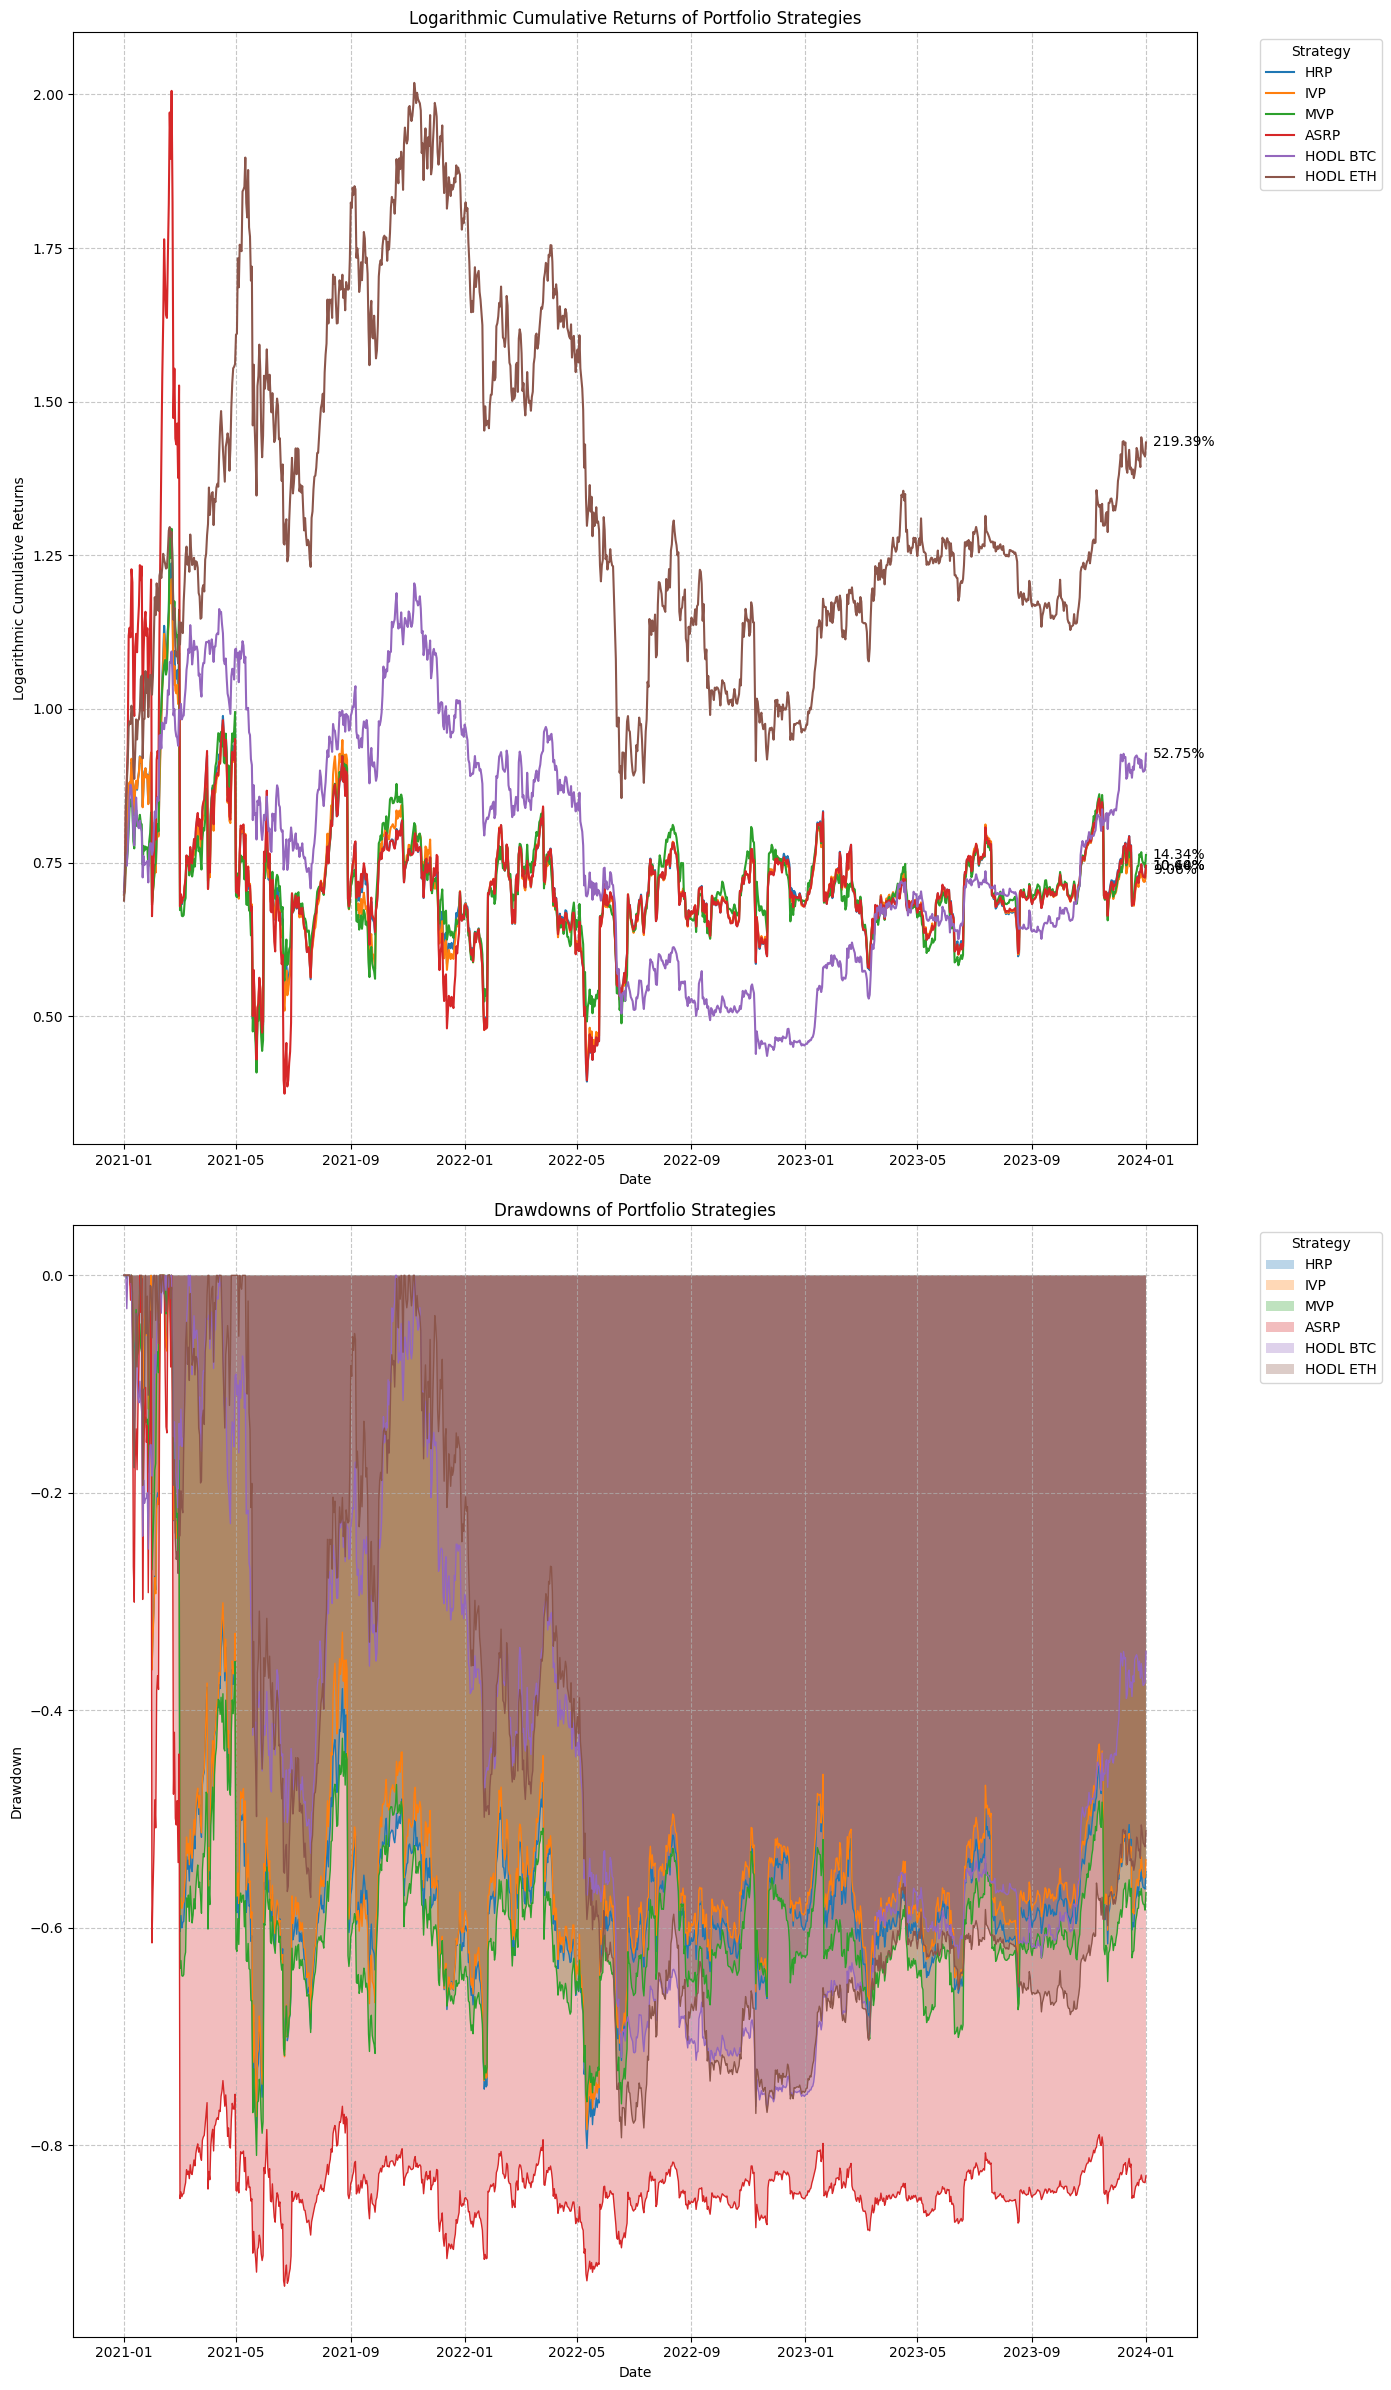

In [23]:
# Add HODL strategies to cumulative returns dataframe
cumulative_returns_dynamic["HODL BTC"] = btc_cumulative
cumulative_returns_dynamic["HODL ETH"] = eth_cumulative

# Calculate drawdowns
hrp_drawdowns = calculate_drawdowns(cumulative_returns_dynamic["HRP"])
ivp_drawdowns = calculate_drawdowns(cumulative_returns_dynamic["IVP"]) 
mvp_drawdowns = calculate_drawdowns(cumulative_returns_dynamic["MVP"])
asrp_drawdowns = calculate_drawdowns(cumulative_returns_dynamic["ASRP"])

drawdowns = pd.DataFrame({
    "HRP": hrp_drawdowns,
    "IVP": ivp_drawdowns,
    "MVP": mvp_drawdowns,
    "ASRP": asrp_drawdowns,
    "HODL BTC": btc_drawdowns,
    "HODL ETH": eth_drawdowns
})

# Create figure with two subplots
fig = plt.figure(figsize=(14, 24))
gs = fig.add_gridspec(2, 1, height_ratios=[1, 1])

# Plot cumulative returns as a line chart
ax1 = fig.add_subplot(gs[0])
for col in cumulative_returns_dynamic.columns:
    line = ax1.plot(cumulative_returns_dynamic.index, np.log1p(cumulative_returns_dynamic[col]), label=col)
    # Add final value annotation with ROI percentage
    final_value = (cumulative_returns_dynamic[col].iloc[-1] - 1) * 100
    ax1.annotate(f'{final_value:.2f}%', 
                 xy=(cumulative_returns_dynamic.index[-1], np.log1p(cumulative_returns_dynamic[col].iloc[-1])),
                 xytext=(5, 0), textcoords='offset points', 
                 va='center')
ax1.set_title("Logarithmic Cumulative Returns of Portfolio Strategies")
ax1.set_xlabel("Date")
ax1.set_ylabel("Logarithmic Cumulative Returns")
ax1.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, linestyle='--', alpha=0.7)

# Plot drawdowns as an area chart
ax2 = fig.add_subplot(gs[1])
for col in drawdowns.columns:
    ax2.fill_between(drawdowns.index, drawdowns[col], alpha=0.3, label=col)
    ax2.plot(drawdowns.index, drawdowns[col], linewidth=1)
ax2.set_title("Drawdowns of Portfolio Strategies")
ax2.set_xlabel("Date")
ax2.set_ylabel("Drawdown")
ax2.legend(title="Strategy", bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

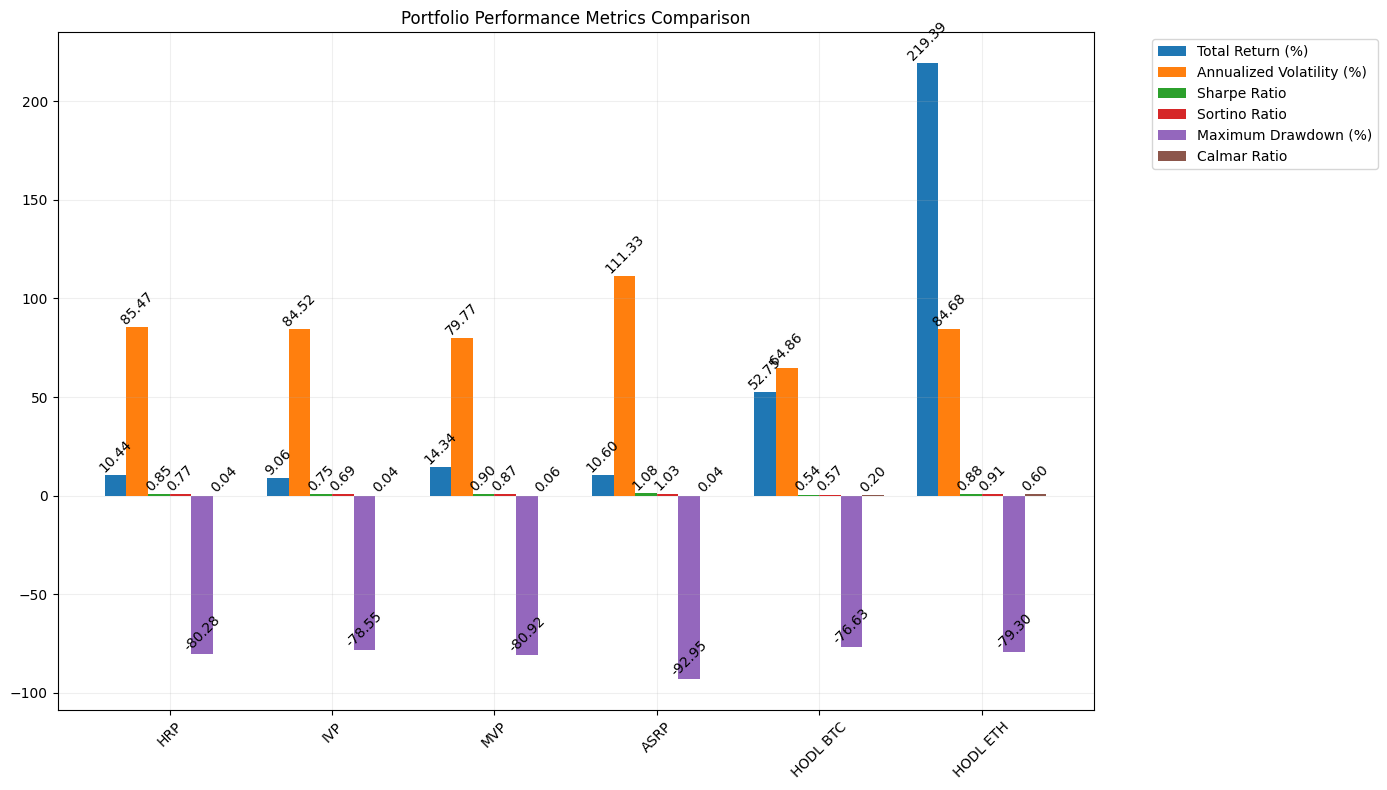

In [24]:
# calculate_performance_metrics(returns_matrix=None, weights=None, portfolio_returns=None, cumulative_returns=None)
metrics_dict = {
    'HRP': calculate_performance_metrics(portfolio_returns=portfolio_returns_dynamic['HRP'], cumulative_returns=cumulative_returns_dynamic['HRP']),
    'IVP': calculate_performance_metrics(portfolio_returns=portfolio_returns_dynamic['IVP'], cumulative_returns=cumulative_returns_dynamic['IVP']),
    'MVP': calculate_performance_metrics(portfolio_returns=portfolio_returns_dynamic['MVP'], cumulative_returns=cumulative_returns_dynamic['MVP']),
    'ASRP': calculate_performance_metrics(portfolio_returns=portfolio_returns_dynamic['ASRP'], cumulative_returns=cumulative_returns_dynamic['ASRP']),
    'HODL BTC': calculate_performance_metrics(portfolio_returns=btc_returns, cumulative_returns=btc_cumulative),
    'HODL ETH': calculate_performance_metrics(portfolio_returns=eth_returns, cumulative_returns=eth_cumulative)
}
plot_performance_metrics(metrics_dict);